# 2 - modéliser
---

**imports des librairies utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**A ] une approche non supervisée : LDA**

**imports des données**

In [ ]:
lda_posts_body_feature_names = np.load("data/lda_posts_body_feature_names.npy", allow_pickle=True)
lda_posts_body_tfidf = np.load("data/lda_posts_body_tfidf.npy" , allow_pickle=True, ).item()
lda_posts_body_tf = np.load("data/lda_posts_body_tf.npy" , allow_pickle=True, ).item() 

In [ ]:
lda_posts_body_tfidf 

In [ ]:
lda_posts_body_tf

**modélisation lda**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5,random_state=11).fit(lda_posts_body_tf)

In [ ]:
# affiche les 10 mots les plus importants par topics
def display_topics(lda, feature_names, nb_tag):
    for x, topic in enumerate(lda.components_):
        print("--------------------------------------------")
        print(f"Topic {x}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1][:nb_tag]]))
        print("--------------------------------------------")

In [ ]:
display_topics(lda, lda_posts_body_feature_names, 10)

**B] une approche supervisée : Multi-label classification**

**imports des données**

In [2]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)

In [3]:
#pd.set_option('display.max_colwidth', 500)

In [4]:
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
# if no title and no body
multi_posts = multi_posts.dropna()

In [5]:
multi_posts.head(5)

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
0,absolutely positioned div containing several c...,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,given datetime representing person birthday ca...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,standard way web server able determine user ti...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,difference math floor math truncate net diff...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,expose linq query asmx web service usually bus...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


**parametres globaux**

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer

def auroc(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    return roc_auc_score(y_true, probs, average="weighted")

my_scorer = make_scorer(auroc, needs_proba=True)

In [6]:
from sklearn.metrics import jaccard_score, make_scorer

def jaccard(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    average_jaccard = np.zeros(size)
    jaccard = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        jaccard.append(jaccard_score(y_pred_class,y_true,average='macro'))
        threshold.append(i)

    return jaccard[np.argmax(jaccard)]

my_scorer = make_scorer(jaccard, needs_proba=True)

In [7]:
import random

random_state=42
#random_state=random.randint(0, 100)
scoring=my_scorer
#scoring='accuracy'

**echantillonages**

In [8]:
multi_posts = multi_posts.sample(5000,random_state=random_state)

In [9]:
multi_posts

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
33023,according mysql manual table comments limited ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135505,lamp server fairly busy cpu usage hovers aroun...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88898,simple sql server database use conversions bas...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
33429,datetime store date mysql column mysqli prepar...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
89391,link site strictly javascript users optionally...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86327,got form repeater webpage number parameter tel...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
585,best way make linked list java create linked...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63975,asp net dynamic data website set application s...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
140155,processing treeview directories files user sel...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


**séparation du jeu de données**

In [10]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(multi_posts, random_state=random_state, test_size=0.2, shuffle=True)
validation, test = train_test_split(validation, random_state=random_state, test_size=0.5, shuffle=True)

In [11]:
X_train, y_train = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_val, y_val = validation['body_title'], validation.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_test, y_test = test['body_title'], test.iloc[:,1:].to_numpy(copy=True, dtype='int32')

**extraction de caractéristiques - tfidf - pour classification**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

multi_tfidf_vectorizer = TfidfVectorizer(max_df= 0.5)

X_train_tfidf = multi_tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = multi_tfidf_vectorizer.transform(X_val)
X_test_tfidf = multi_tfidf_vectorizer.transform(X_test)

In [13]:
X_val_tfidf.shape

(500, 21104)

In [72]:
["javascript security techniques issues"]

89102    javascript security techniques issues limitati...
Name: body_title, dtype: object

In [74]:
multi_tfidf_vectorizer.transform(["javascript security techniques issues"])

<1x21104 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

**transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [14]:
"""from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_tfidf)

X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_val_tfidf_scaled = scaler.transform(X_val_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)"""

'from sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X_train_tfidf)\n\nX_train_tfidf_scaled = scaler.transform(X_train_tfidf)\nX_val_tfidf_scaled = scaler.transform(X_val_tfidf)\nX_test_tfidf_scaled = scaler.transform(X_test_tfidf)'

**modélisation et optimisation principale**   
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

In [15]:
from sklearn.utils.multiclass import is_multilabel

print(is_multilabel(y_train))

True


**fonction rapport classification**

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

def get_metrics(y_true, y_score, index , decimals=3):
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    dict_metrics = {}
    #dict_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    dict_metrics['jaccard'] = jaccard(y_true, y_score)
    #dict_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    dict_metrics['aupr'] = average_precision_score(y_true, probs, average='weighted')
    #dict_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    dict_metrics['auroc'] = roc_auc_score(y_true, probs, average="weighted")

    metrics = pd.DataFrame(dict_metrics, index=[index])
    
    return metrics.round(decimals)

In [18]:
#init le rapport
classification_report = pd.DataFrame()

**fonctions perso d'affichage de classification**

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import multilabel_confusion_matrix


def plot_auroc(y_true, y_score, labels):
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    for i in range(20):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], probs[:, i])
        plt.figure()
        plt.plot(fpr[i], tpr[i])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.ylim([-0.05, 1.05])
        plt.xlim([-0.05, 1.05])
        plt.title(labels[i])
        

def plot_aupr(y_true, y_score, labels):
    precision = dict()
    recall = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    for i in range(20):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        plt.figure()
        plt.plot(recall[i], precision[i])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title(labels[i])
        
def plot_matconf(y_true, y_pred, labels):
    ml_confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

    for i, label in enumerate(labels):
        fig, ax = plt.subplots(figsize=(2,2))
        plt.title(label)
        sns.heatmap(ml_confusion_matrix[i],annot=True, cbar=None,linewidths=.5, fmt="d")
        


def plot_accuracy(y_true, y_score, labels):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    average_accuracy = np.zeros(size)
    for j in range(20):
        accuracy = []
        threshold = []
        for i in np.linspace(0, 1.0, num=size):
            y_pred_class = np.array(probs[:, j]) > i
            accuracy.append(accuracy_score(y_pred_class,y_true[:, j]))
            threshold.append(i)
        average_accuracy = np.sum([average_accuracy, accuracy], axis=0)

        plt.figure()
        plt.plot(threshold, accuracy)
        plt.xlabel('Threshold')
        plt.ylabel('Accuracy_score')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title(labels[j])
    print("with threshold = ",threshold[np.argmax(average_accuracy)])
    print("best average accuracy score = ", average_accuracy[np.argmax(average_accuracy)]/20)
    

def plot_jaccard(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    average_jaccard = np.zeros(size)
    jaccard = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        jaccard.append(jaccard_score(y_pred_class,y_true,average='macro'))
        threshold.append(i)

    plt.figure()
    plt.plot(threshold, jaccard)
    plt.xlabel('Threshold')
    plt.ylabel('jaccard_score')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Jaccard score')
    
    print("best jaccard score = ", jaccard[np.argmax(jaccard)])
    
    plt.hlines(y=jaccard[np.argmax(jaccard)], xmin=0, xmax=1, color="red")

**0) classification baseline**

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier

#“stratified”: generates predictions by respecting the training set’s class distribution.

dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier = MultiOutputClassifier(dummy_classifier).fit(X_train_tfidf, y_train)

In [23]:
y_score_train = dummy_classifier.predict_proba(X_train_tfidf)
y_pred_train = dummy_classifier.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'dummy_classifier_on_train'))

In [24]:
y_score_val = dummy_classifier.predict_proba(X_val_tfidf)
y_pred_val = dummy_classifier.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'dummy_classifier_on_val'))

**1) classification logistic regression**

In [25]:
X_train_tfidf.shape

(4000, 21104)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

logistic_regression = LogisticRegression()
logistic_regression = MultiOutputClassifier(logistic_regression)

n_C = 10
estimator__C = np.logspace(-3, 10, n_C)
n_jobs=[4]
estimator__max_iter = [400]

hyperparameters = dict(estimator__max_iter = estimator__max_iter,
                       estimator__C = estimator__C,
                       n_jobs = n_jobs
                      )

gscv_logistic_regression = GridSearchCV(logistic_regression, hyperparameters, cv=KFold(4,shuffle=True, random_state=random_state), scoring=scoring , verbose=2)
gscv_logistic_regression.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END estimator__C=0.001, estimator__max_iter=400, n_jobs=4; total time=   2.3s
[CV] END estimator__C=0.001, estimator__max_iter=400, n_jobs=4; total time=   1.1s
[CV] END estimator__C=0.001, estimator__max_iter=400, n_jobs=4; total time=   1.1s
[CV] END estimator__C=0.001, estimator__max_iter=400, n_jobs=4; total time=   1.1s
[CV] END estimator__C=0.027825594022071243, estimator__max_iter=400, n_jobs=4; total time=   1.2s
[CV] END estimator__C=0.027825594022071243, estimator__max_iter=400, n_jobs=4; total time=   1.2s
[CV] END estimator__C=0.027825594022071243, estimator__max_iter=400, n_jobs=4; total time=   1.2s
[CV] END estimator__C=0.027825594022071243, estimator__max_iter=400, n_jobs=4; total time=   1.2s
[CV] END estimator__C=0.774263682681127, estimator__max_iter=400, n_jobs=4; total time=   1.7s
[CV] END estimator__C=0.774263682681127, estimator__max_iter=400, n_jobs=4; total time=   1.8s
[CV] END estimator__C=0.7

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': array([1.00000000e-03, 2.78255940e-02, 7.74263683e-01, 2.15443469e+01,
       5.99484250e+02, 1.66810054e+04, 4.64158883e+05, 1.29154967e+07,
       3.59381366e+08, 1.00000000e+10]),
                         'estimator__max_iter': [400], 'n_jobs': [4]},
             scoring=make_scorer(jaccard, needs_proba=True), verbose=2)

In [27]:
gscv_logistic_regression.best_params_

{'estimator__C': 599.4842503189409, 'estimator__max_iter': 400, 'n_jobs': 4}

In [28]:
gscv_logistic_regression.cv_results_

{'mean_fit_time': array([1.28778499, 1.0683713 , 1.56060904, 2.74448603, 3.78892517,
        3.28580332, 2.38773894, 1.79301959, 1.79725957, 1.76870638]),
 'std_fit_time': array([0.50149382, 0.01460792, 0.07213999, 0.04056617, 0.24471231,
        0.10669723, 0.08550716, 0.0060939 , 0.0376706 , 0.0332434 ]),
 'mean_score_time': array([0.20949173, 0.21097863, 0.22667712, 0.21838939, 0.21839941,
        0.2193138 , 0.22302032, 0.22427952, 0.22109175, 0.22179198]),
 'std_score_time': array([0.00146886, 0.00199298, 0.01018628, 0.00111683, 0.00089032,
        0.00184759, 0.00666971, 0.00870952, 0.00245614, 0.00265583]),
 'param_estimator__C': masked_array(data=[0.001, 0.027825594022071243, 0.774263682681127,
                    21.54434690031882, 599.4842503189409,
                    16681.005372000593, 464158.8833612772,
                    12915496.650148828, 359381366.3804626, 10000000000.0],
              mask=[False, False, False, False, False, False, False, False,
                    

In [29]:
y_score_train = gscv_logistic_regression.predict_proba(X_train_tfidf)
y_pred_train = gscv_logistic_regression.predict(X_train_tfidf)

classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'logistic_regression_on_train'))

In [30]:
y_score_val = gscv_logistic_regression.predict_proba(X_val_tfidf)
y_pred_val = gscv_logistic_regression.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'logistic_regression_on_val'))

**matrice de confusion**

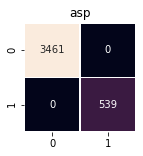

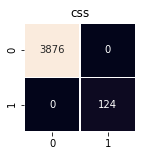

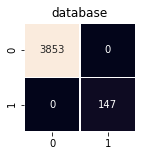

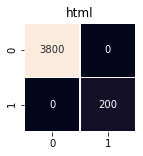

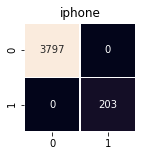

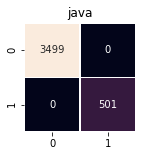

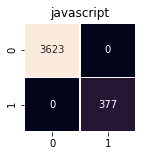

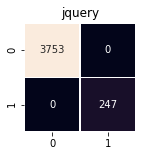

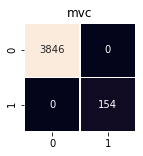

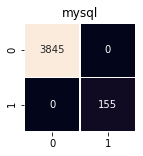

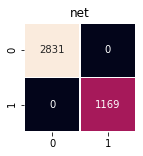

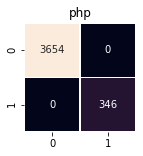

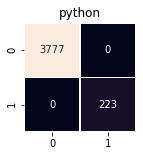

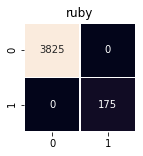

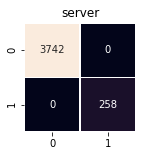

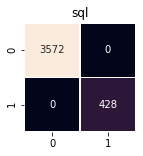

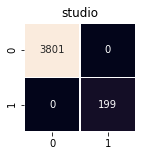

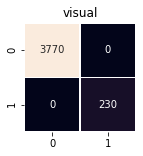

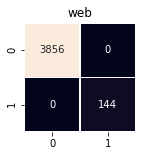

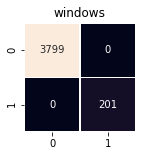

In [31]:
plot_matconf(y_train,y_pred_train, labels=tags.columns.tolist())
#plot_matconf(y_val,y_pred_val, labels=tags.columns.tolist())

**courbe ROC pour chaques étiquettes**

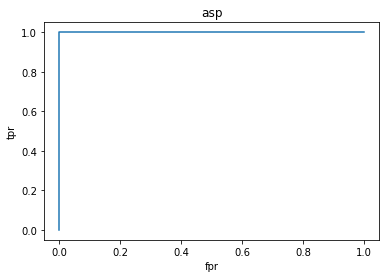

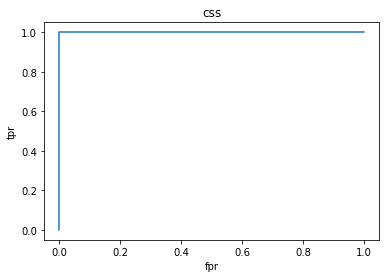

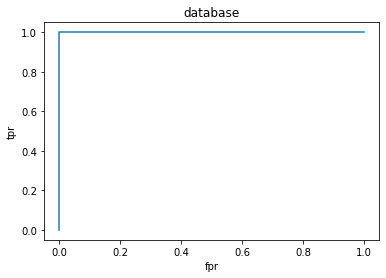

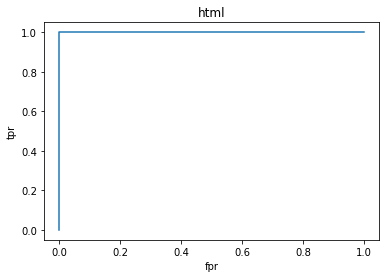

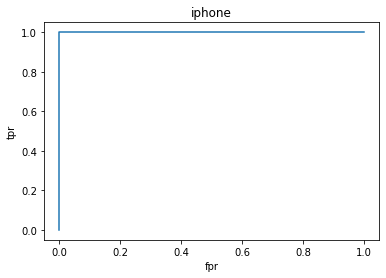

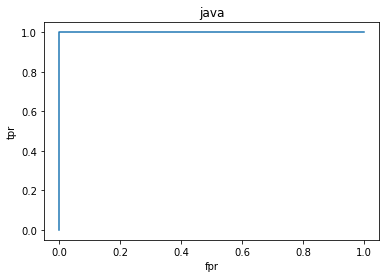

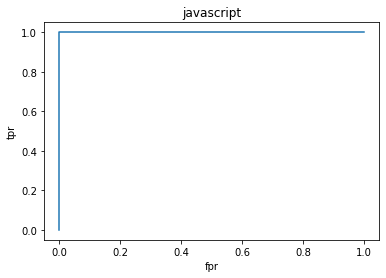

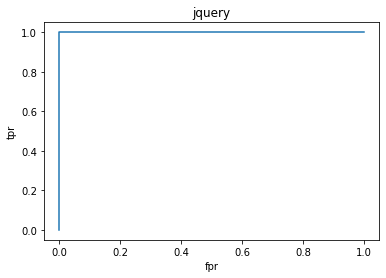

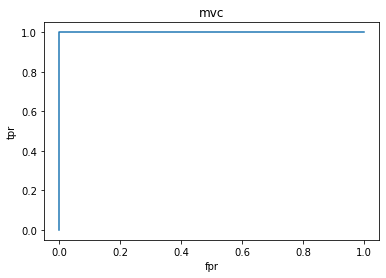

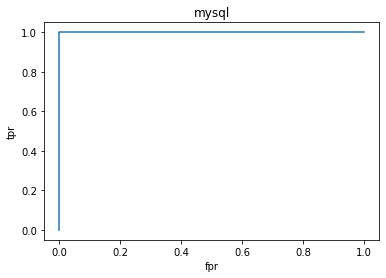

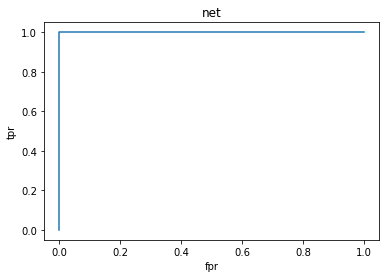

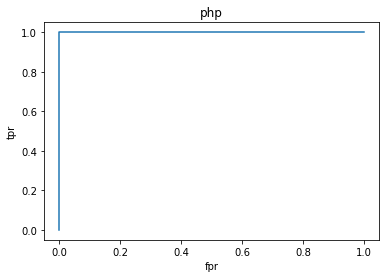

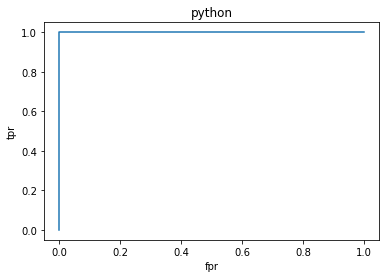

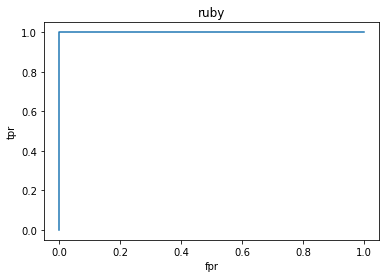

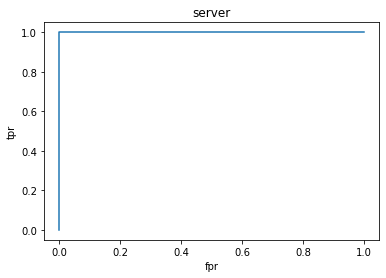

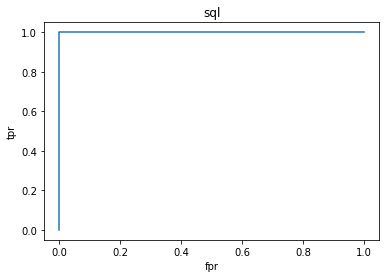

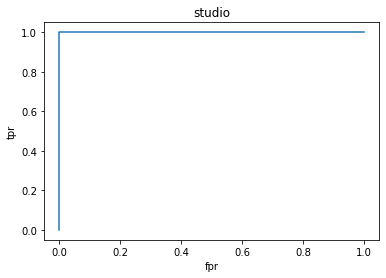

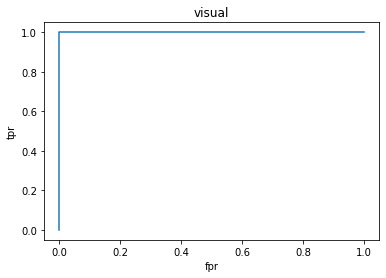

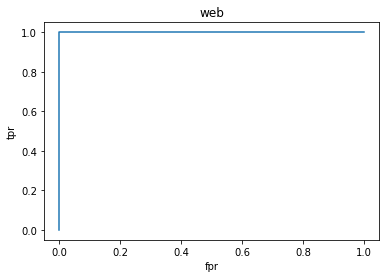

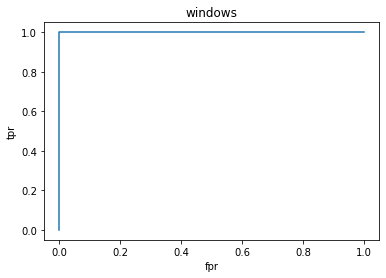

In [32]:
plot_auroc(y_train,y_score_train, labels=tags.columns.tolist())
#plot_auroc(y_val,y_score_val, labels=tags.columns.tolist())

**courbe precision-recall pour chaques étiquettes**

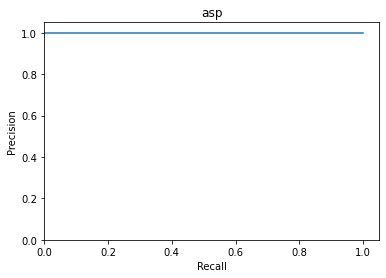

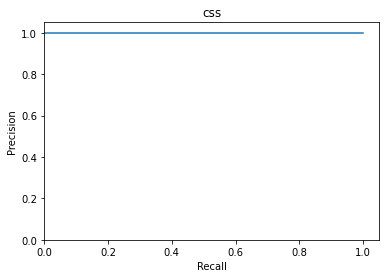

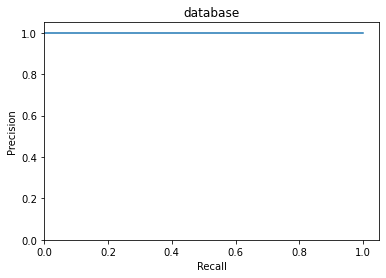

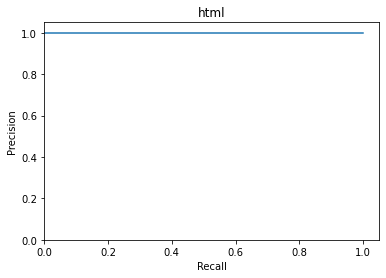

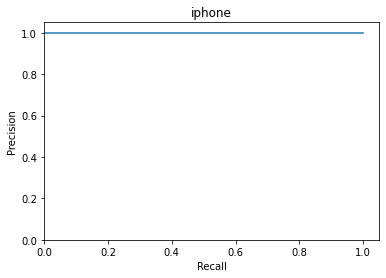

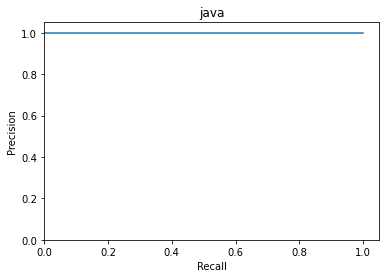

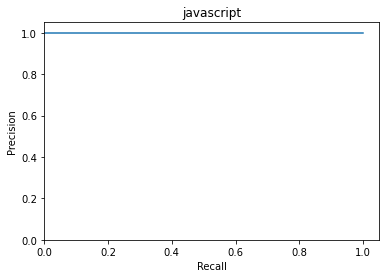

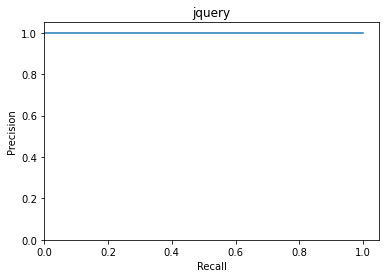

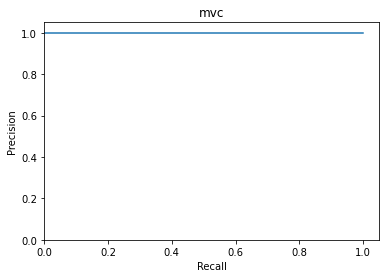

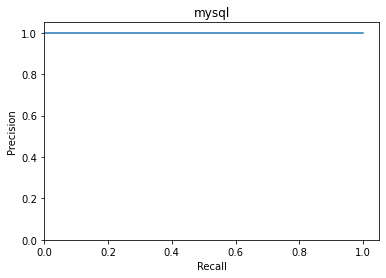

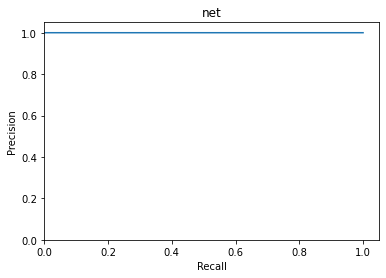

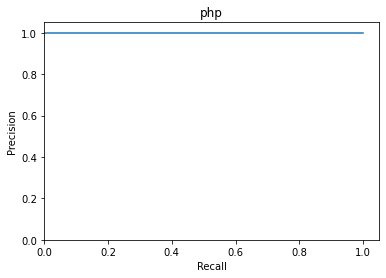

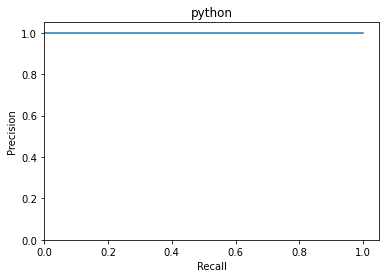

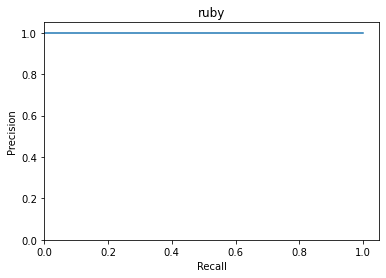

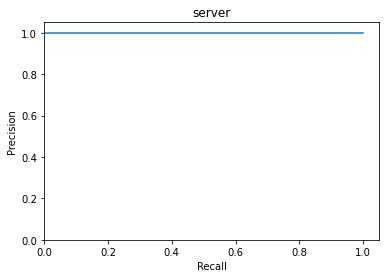

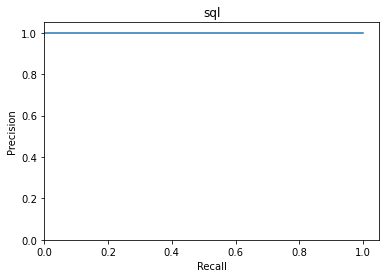

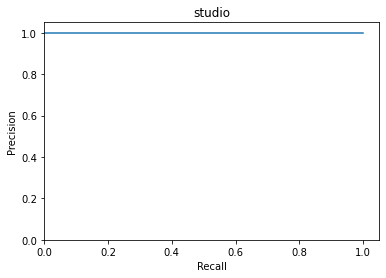

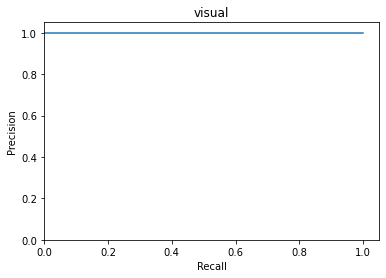

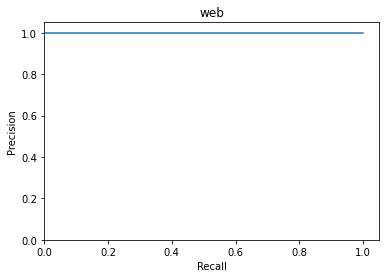

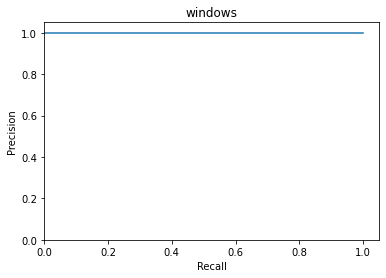

In [33]:
plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())
#plot_aupr(y_val,y_score_val, labels=tags.columns.tolist())

**courbe accuracy pour chaques étiquettes**

with threshold =  0.10101010101010102
best average accuracy score =  1.0


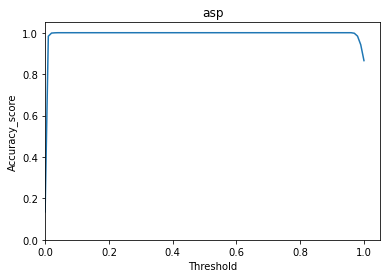

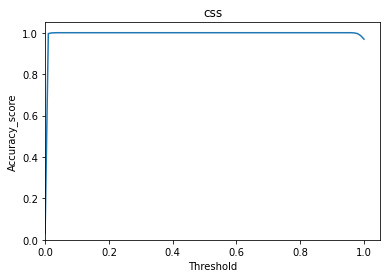

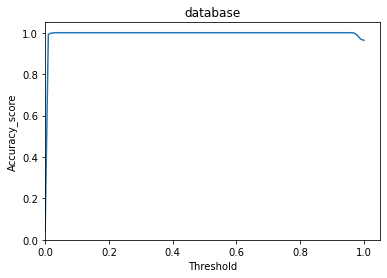

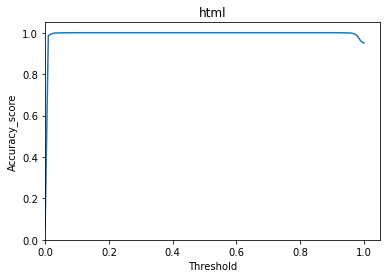

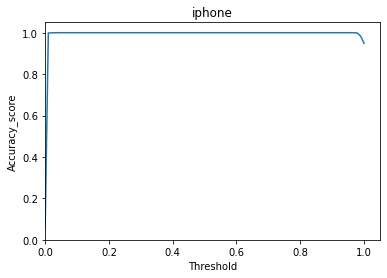

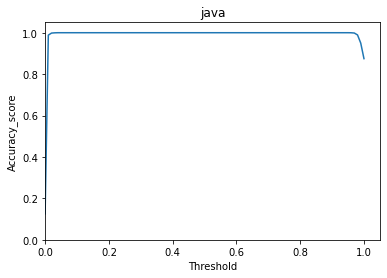

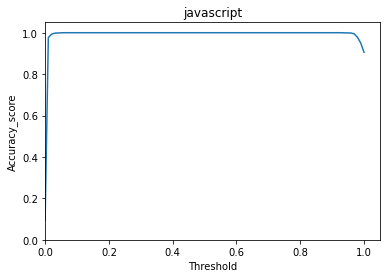

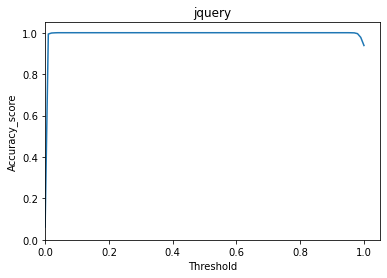

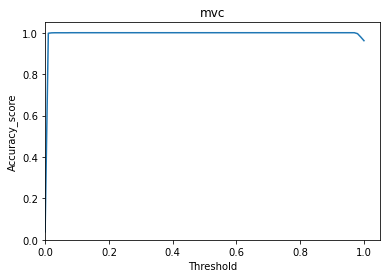

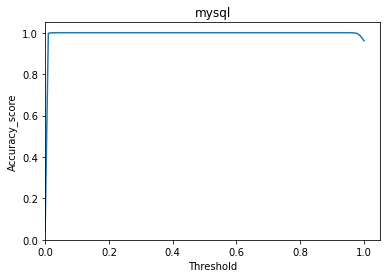

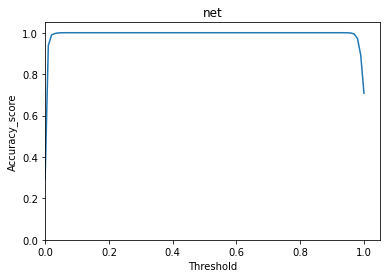

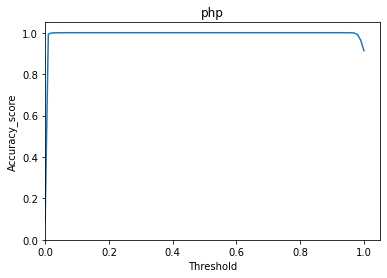

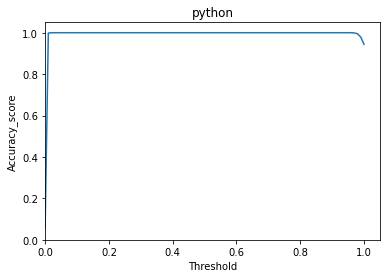

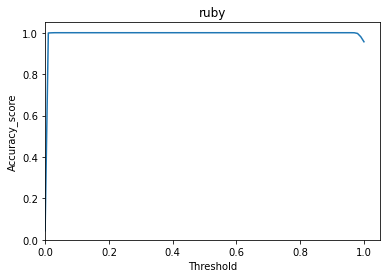

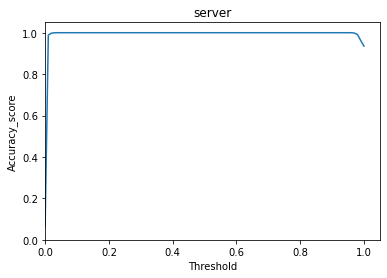

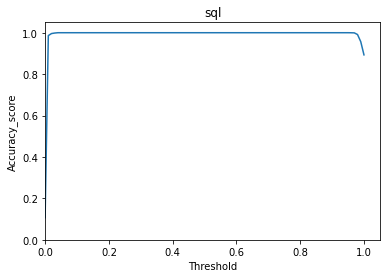

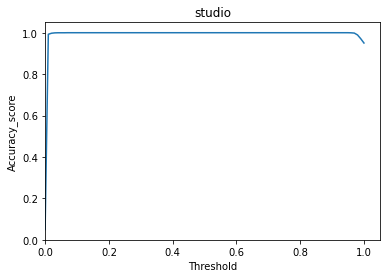

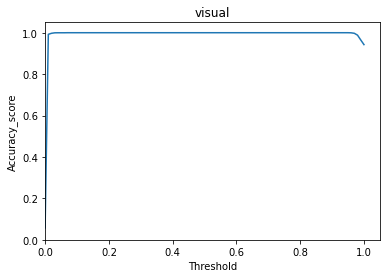

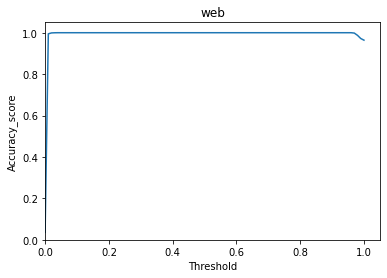

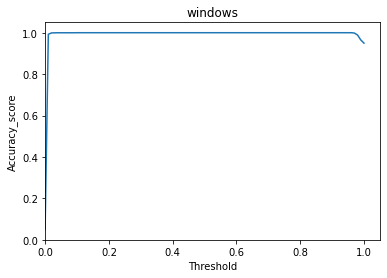

In [37]:
plot_accuracy(y_train,y_score_train, labels=tags.columns.tolist())
#plot_accuracy(y_val,y_score_val, labels=tags.columns.tolist())

**courbe jaccard**

best jaccard score =  1.0


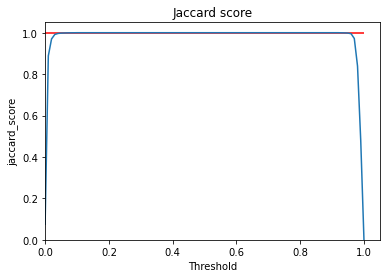

In [38]:
plot_jaccard(y_train,y_score_train)

best jaccard score =  0.5646527796008843


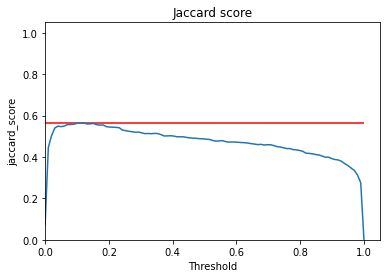

In [39]:
plot_jaccard(y_val,y_score_val)

**1) classification Random Forest**

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

random_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 5)]
#max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparameters = dict(n_estimators = n_estimators,
                       max_features = max_features,
                       max_depth = max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap,
                       n_jobs = n_jobs
                      )

rscv_random_forest = RandomizedSearchCV(random_forest, hyperparameters, n_iter = 50, cv=KFold(3,shuffle=True, random_state=random_state), verbose=2 , random_state=random_state, scoring=scoring)

rscv_random_forest.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   5.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   5.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   5.4s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.3s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.3s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_sa

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   7.3s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.6s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.6s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.7s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.8s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.8s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4;

[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   2.4s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   2.1s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.4s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.4s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jo

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 9, 16, 23, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [400, 700, 1000],
                                        'n_jobs': [4]},
                   random_state=42,
                   scoring=make_scorer(jaccard, needs_proba=True), verbose=2)

In [43]:
rscv_random_forest.cv_results_

{'mean_fit_time': array([ 4.03567815,  1.94569802,  9.5873514 ,  3.14127247,  4.92427945,
         2.86623073,  1.00236909,  3.77441756,  1.46444607,  5.83253018,
         0.88249866,  1.68774263,  5.92486437,  1.22881317,  2.16109665,
         2.27866936,  9.67020392,  2.90984591,  5.87872148,  2.18347979,
         2.42549459,  4.45469975,  1.68495027,  5.72753119,  6.27257919,
         2.04580323,  1.81111987,  1.54956579,  1.57048408,  2.16595459,
         3.64400188,  5.00460768,  7.59897598,  8.05656743,  2.43154875,
         8.52972627,  2.23563639,  1.44590465,  3.98994644,  3.52981702,
         0.92239563, 11.056113  ,  4.24659077,  4.39327494,  4.94357729,
         1.93711233,  3.65760239,  2.01460679,  7.19129976,  0.8736136 ]),
 'std_fit_time': array([0.02416359, 0.02644575, 0.07707142, 0.02583556, 0.04390722,
        0.05043757, 0.06355742, 0.01103726, 0.00480421, 0.03521535,
        0.01442886, 0.02954902, 0.07568502, 0.00505525, 0.01172394,
        0.02758386, 0.14469956,

In [44]:
y_score_train = rscv_random_forest.best_estimator_.predict_proba(X_train_tfidf)
y_pred_train = rscv_random_forest.best_estimator_.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'random_forest_on_train'))

In [45]:
y_score_val = rscv_random_forest.best_estimator_.predict_proba(X_val_tfidf)
y_pred_val = rscv_random_forest.best_estimator_.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'random_forest_on_val'))

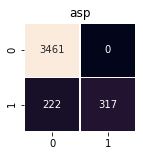

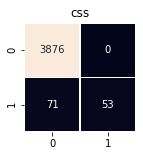

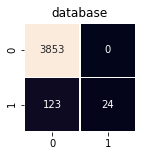

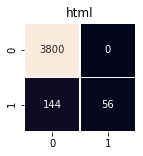

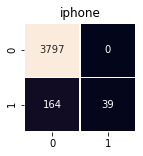

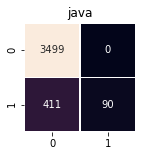

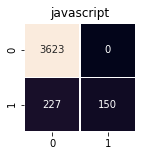

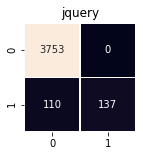

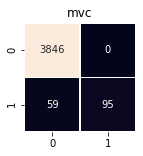

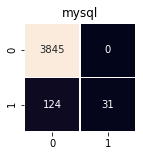

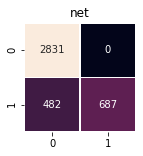

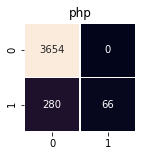

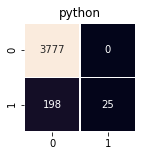

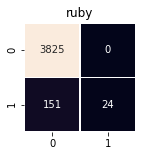

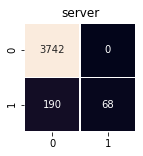

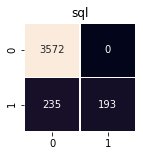

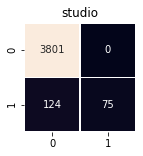

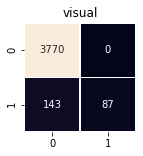

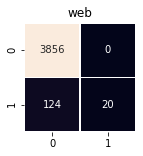

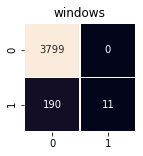

In [46]:
plot_matconf(y_train,y_pred_train, labels=tags.columns.tolist())
#plot_matconf(y_val,y_pred_val)

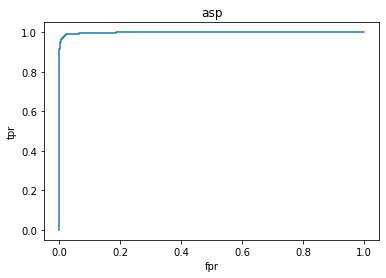

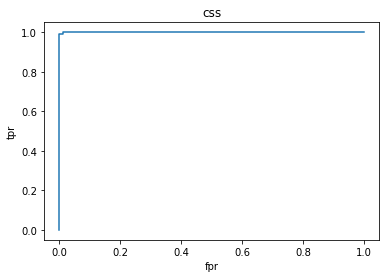

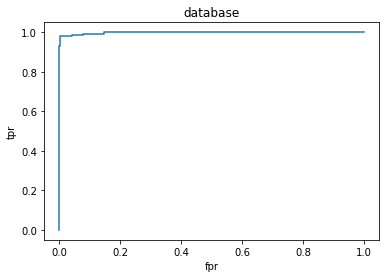

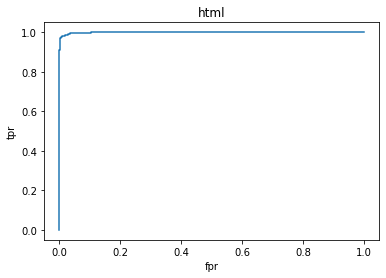

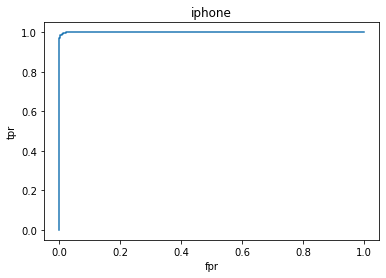

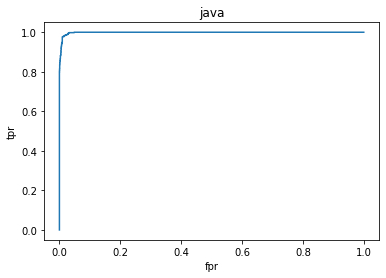

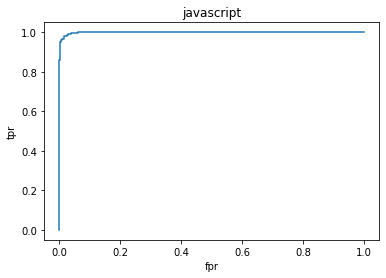

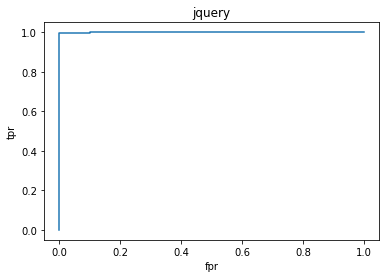

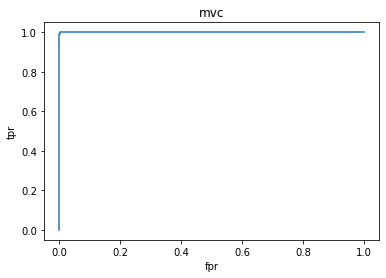

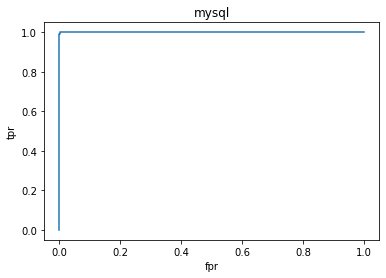

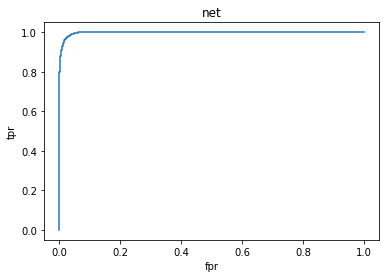

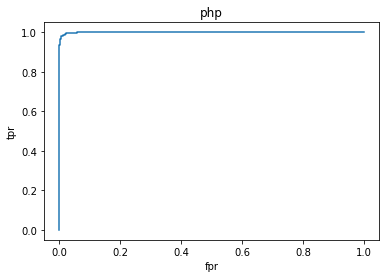

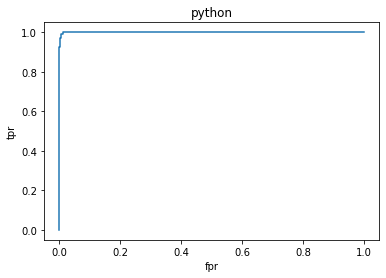

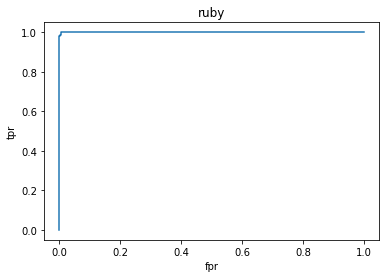

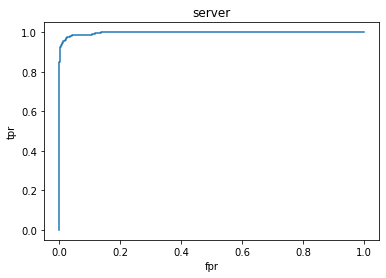

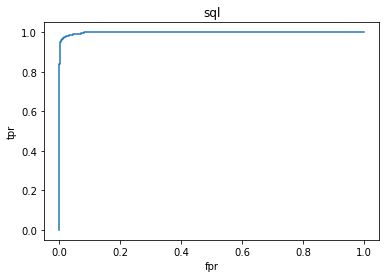

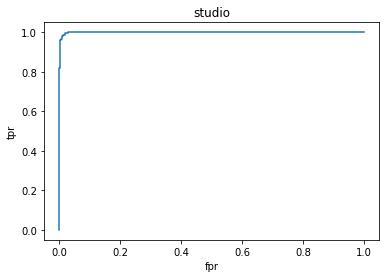

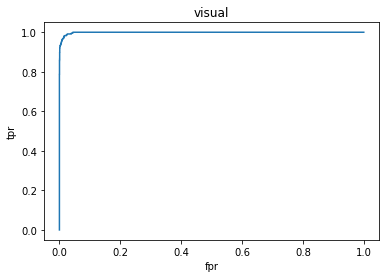

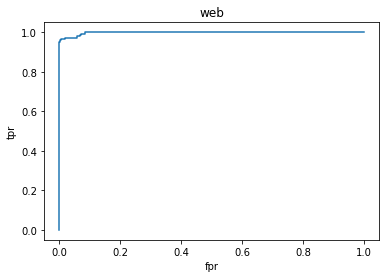

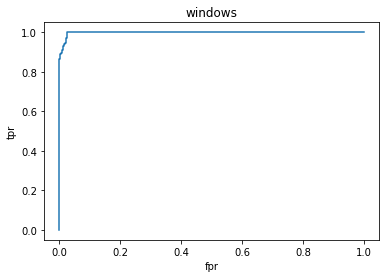

In [47]:
plot_auroc(y_train,y_score_train, labels=tags.columns.tolist())
#plot_auroc(y_train,y_score_train, labels=tags.columns.tolist())

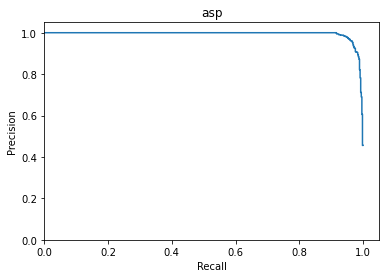

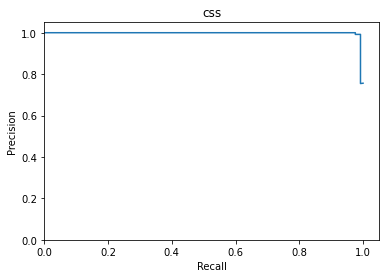

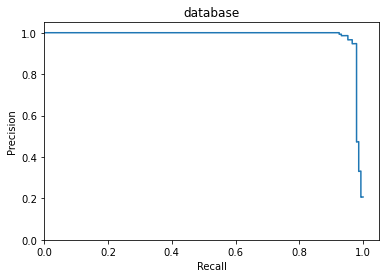

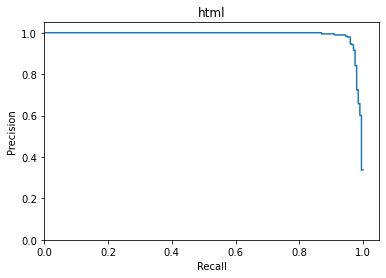

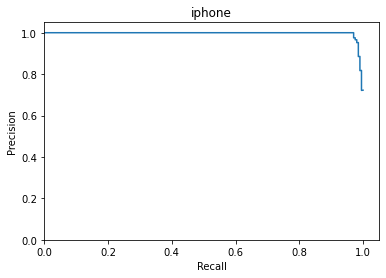

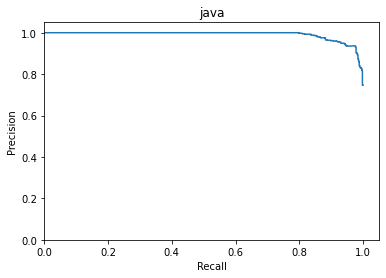

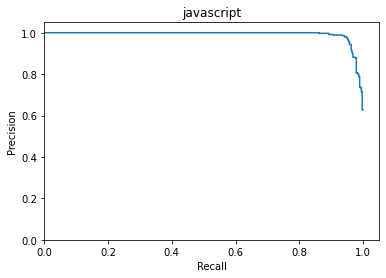

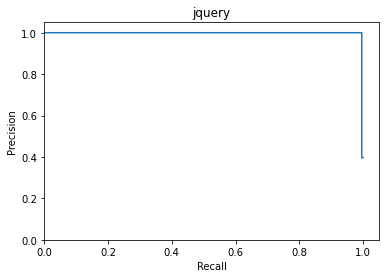

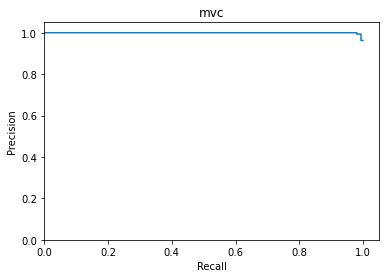

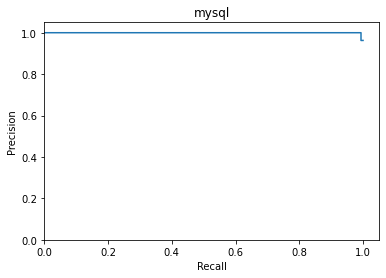

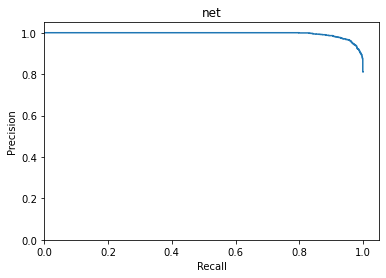

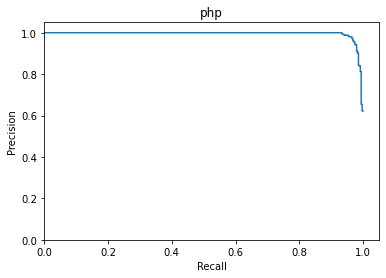

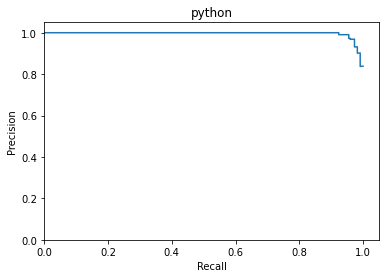

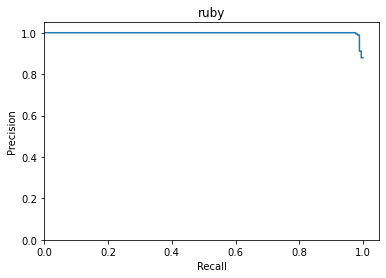

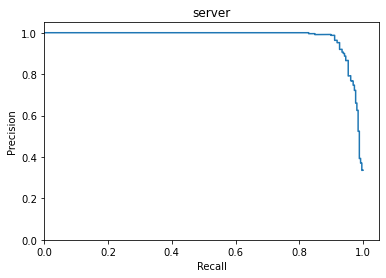

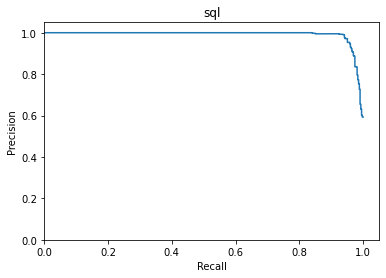

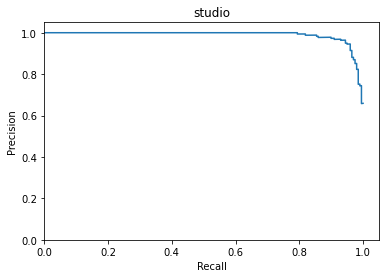

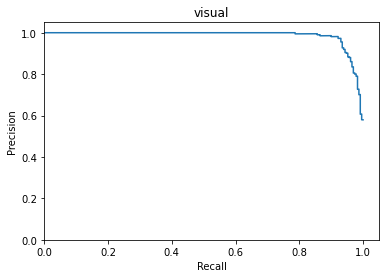

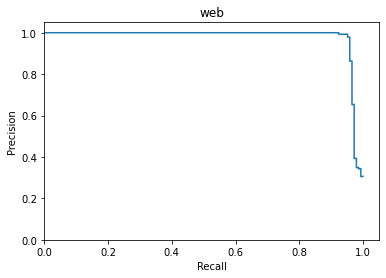

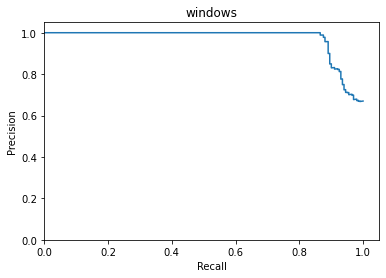

In [48]:
plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())
#plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())

with threshold =  0.26262626262626265
best average accuracy score =  0.9856875


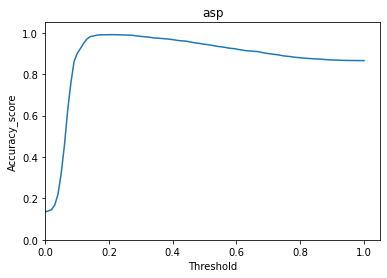

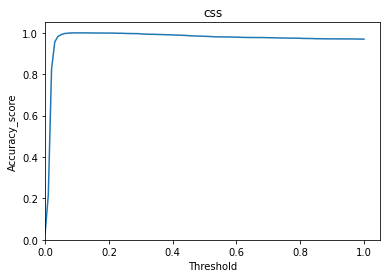

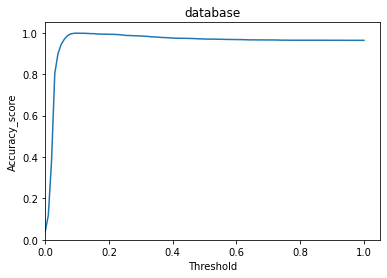

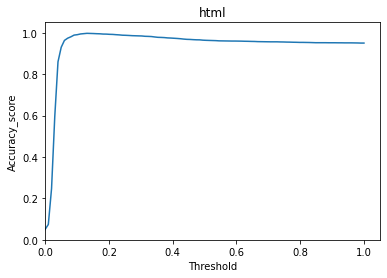

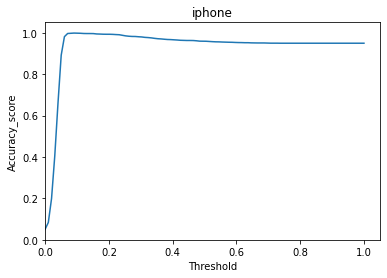

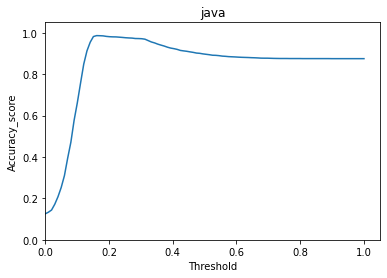

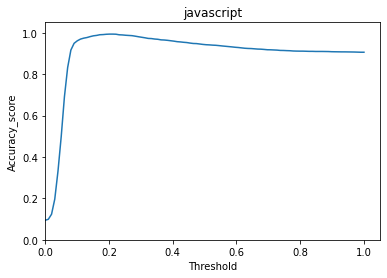

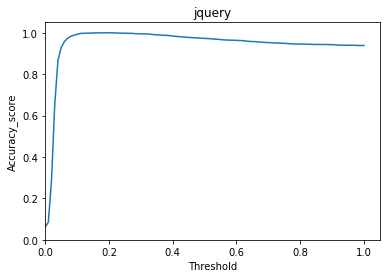

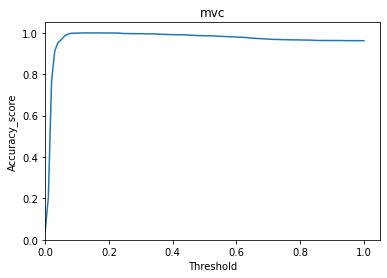

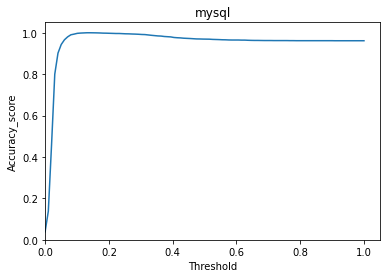

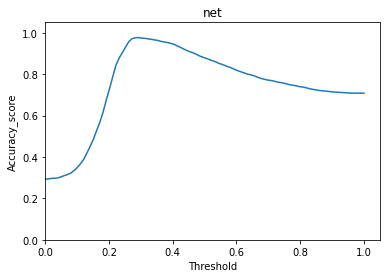

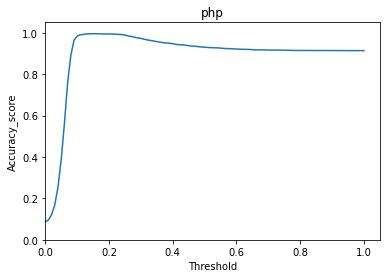

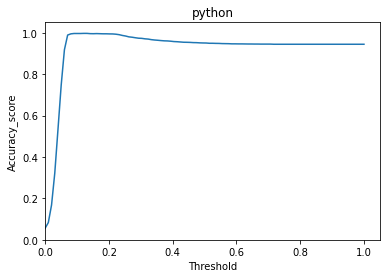

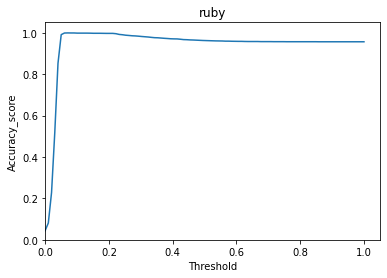

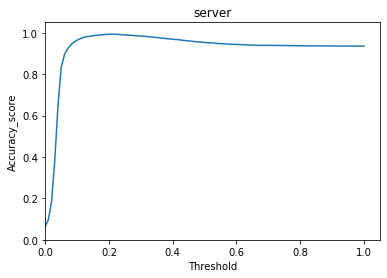

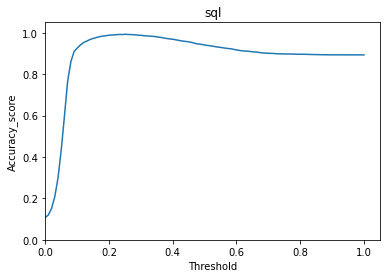

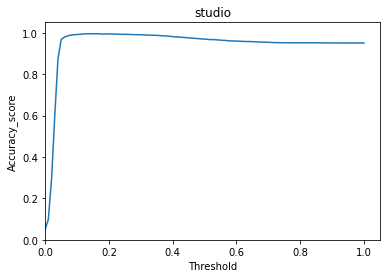

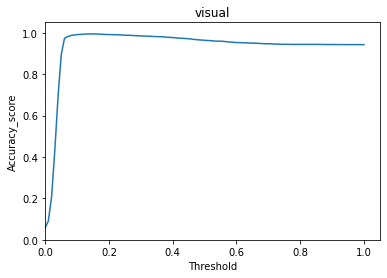

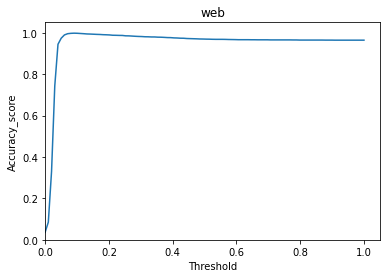

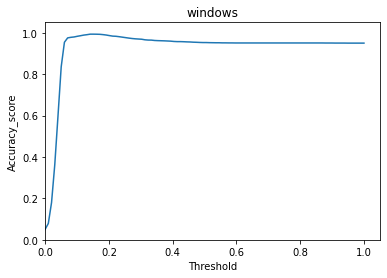

In [49]:
plot_accuracy(y_train,y_score_train, labels=tags.columns.tolist())
#plot_accuracy(y_val,y_score_val, labels=tags.columns.tolist())

best jaccard score =  0.8734576442682043


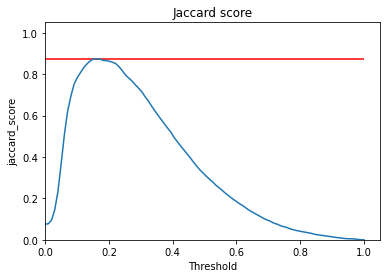

In [50]:
plot_jaccard(y_train,y_score_train)
#plot_jaccard(y_val,y_score_val)

best jaccard score =  0.5084312715851804


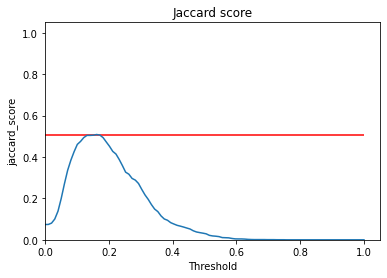

In [51]:
plot_jaccard(y_val,y_score_val)

In [ ]:
from sklearn.feature_selection import SelectFromModel

rscv_random_forest.best_estimator_.feature_importances_

X_train_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_train_tfidf)
X_val_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_val_tfidf)
X_test_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_test_tfidf)

**rapport de Classification**

<AxesSubplot:title={'center':'Train - Rapport de classification'}>

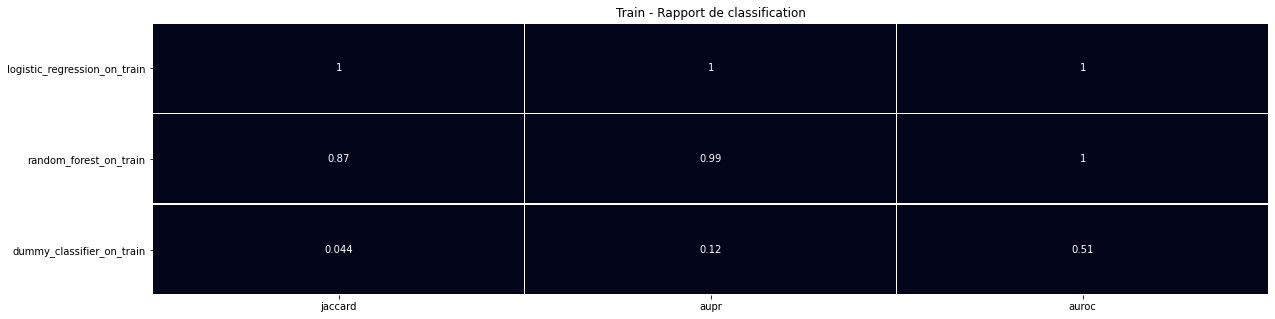

In [52]:
cr = classification_report[classification_report.index.str.contains('train$')].sort_values(by=['auroc'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de classification'}>

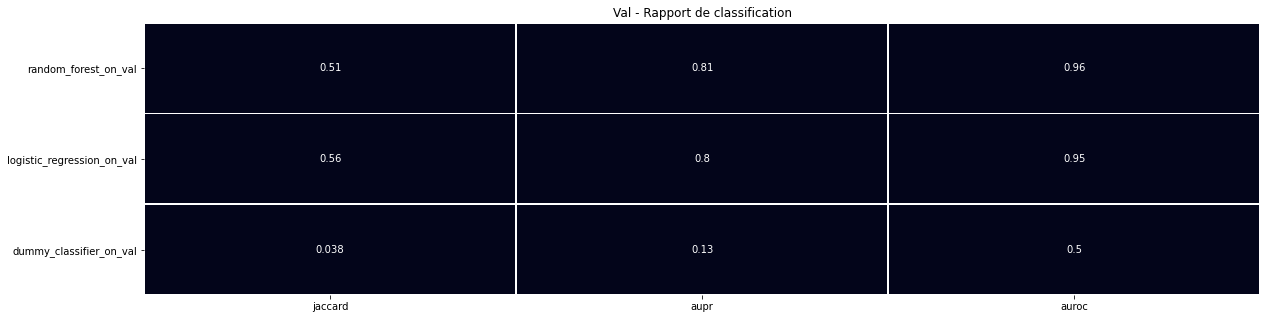

In [53]:
cr = classification_report[classification_report.index.str.contains('val$')].sort_values(by=['auroc'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**Test à l'échelle**

In [ ]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
multi_posts = multi_posts.dropna()
X, y = multi_posts['body_title'], multi_posts.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_tfidf = multi_tfidf_vectorizer.transform(X)
classification_report = pd.DataFrame()

In [ ]:
y_pred = gscv_logistic_regression.predict(X_tfidf)
classification_report = classification_report.append(get_metrics(y, y_pred, 'logistic_regression_on_all'))

In [ ]:
y_pred = gscv_random_forest.predict(X_tfidf)
classification_report = classification_report.append(get_metrics(y, y_pred, 'random_forest_on_all'))

In [ ]:
cr = classification_report[classification_report.index.str.contains('all$')].sort_values(by=['roc_auc_score'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('all - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**fonction pour api prediction**

In [ ]:
# retourne les étiquettes pour les predictions
def labels(predictions, labels):
    preds = []
    for prediction in predictions:
        pred = []
        for i, is_label in enumerate(prediction):
            if is_label == 0:
                pass
            else :
                pred.append(labels[i])
        preds.append(pred)
    return preds
        
labels(y_pred_val, labels=tags.columns.tolist())

In [77]:
y_pred_val.shape

(500, 20)

**export modele pour api prediction**

In [55]:
import pickle

#model
filename = 'logistic_regression.sav'
pickle.dump(gscv_logistic_regression, open(filename, 'wb'))

#vectorizer
filename = 'multi_tfidf_vectorizer.sav'
pickle.dump(multi_tfidf_vectorizer, open(filename, 'wb'))

In [76]:
#labels
my_labels = pd.Series(tags.columns.tolist())
my_labels.to_csv("data/my_labels.csv", index=False)